In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
import os
from random import shuffle
from glob import glob
from zipfile import ZipFile
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_zip = '../input/dogs-vs-cats-redux-kernels-edition/train.zip'
with ZipFile(train_zip, 'r') as Zip:
  Zip.extractall()
test_zip = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'
with ZipFile(test_zip, 'r') as Zip:
  Zip.extractall()
  print('Done')

Done


In [3]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return preprocess_input(img)  # предобработка для ResNet50

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [4]:
base_model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
# определяем один из слоев для выхода и применяем к нему головные слои
x = base_model.layers[-6].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [7]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
val_samples = int(0.2*len(train_files))

shuffle(train_files)

validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])


model.fit(train_data, steps_per_epoch=10, epochs=50, validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 2.1616 - accuracy: 0.5893 - val_loss: 0.7548 - val_accuracy: 0.8134
Epoch 2/50
10/10 [==============================] - 10s 1s/step - loss: 0.5343 - accuracy: 0.8918 - val_loss: 0.1240 - val_accuracy: 0.9702
Epoch 3/50
10/10 [==============================] - 10s 1s/step - loss: 0.2735 - accuracy: 0.9533 - val_loss: 0.1179 - val_accuracy: 0.9752
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 0.1623 - accuracy: 0.9715 - val_loss: 0.1066 - val_accuracy: 0.9764
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 0.0823 - accuracy: 0.9822 - val_loss: 0.1086 - val_accuracy: 0.9772
Epoch 6/50
10/10 [==============================] - 10s 1s/step - loss: 0.0315 - accuracy: 0.9952 - val_loss: 0.1019 - val_accuracy: 0.9764
Epoch 7/50
10/10 [==============================] - 10s 1s/step - loss: 0.0968 - accuracy: 0.9837 - val_loss: 0.1027 - val_accuracy: 0.9792
Epoch 8/50
10/10 [==

Epoch 50/50  
10/10  - 10s 1s/step - loss: 0.1168 - accuracy: 0.9750 - val_loss: 0.1080 - val_accuracy: 0.9804

In [10]:
model.save('dogs_vs_cats_ResNet50.hdf5')

In [11]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

In [15]:
with open('dogs_vs_cats_submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Посмотрим на классификацию модели первых 10 изобаржений из тестовых данных.

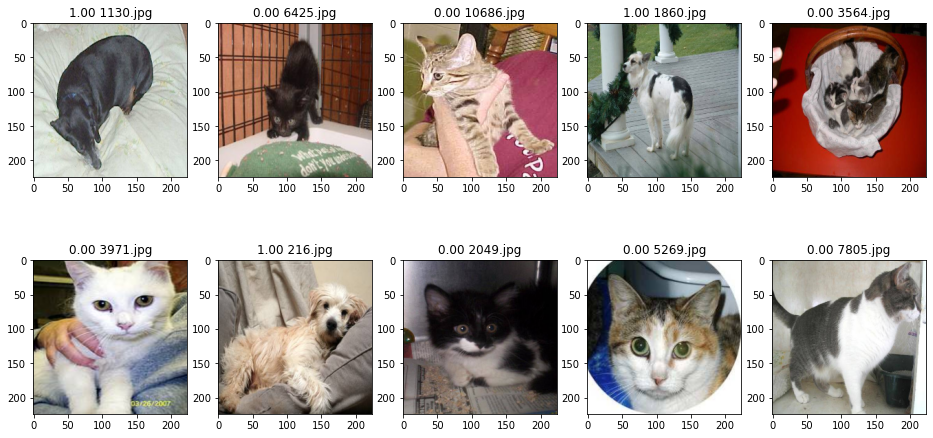

In [13]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)